Text To SQL Agent

In [1]:
from dotenv import load_dotenv
load_dotenv('.env')	
import os

In [2]:
from langchain_community.utilities import SQLDatabase
def func():
    db = SQLDatabase.from_uri("sqlite:///Chinook.db")
    return db

In [3]:
db= func()
db.dialect

'sqlite'

In [4]:
db.run("SELECT title FROM Album LIMIT 5")

"[('For Those About To Rock We Salute You',), ('Balls to the Wall',), ('Restless and Wild',), ('Let There Be Rock',), ('Big Ones',)]"

LLM Connection

In [5]:
from langchain_ollama import ChatOllama
base_url = "http://localhost:11434/"
llm = ChatOllama(model="qwen2.5:3b", base_url=base_url)

In [6]:
# llm.invoke("Hello, how are you?")


Application State

In [7]:
from typing import TypedDict, Annotated

class State(TypedDict):
    prompt: str
    query: str
    sqlOutput: str
    llmOutput: str

In [8]:
from langchain import hub

promptTemplate = hub.pull("langchain-ai/sql-query-system-prompt")


In [9]:
promptTemplate.messages[0].pretty_print()

================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


Write, Execute & Generate SQL Response

In [10]:
db.get_table_info()

'\nCREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n\n\nCREATE TABLE "Artist" (\n\t"ArtistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("ArtistId")\n)\n\n/*\n3 rows from Artist table:\nArtistId\tName\n1\tAC/DC\n2\tAccept\n3\tAerosmith\n*/\n\n\nCREATE TABLE "Customer" (\n\t"CustomerId" INTEGER NOT NULL, \n\t"FirstName" NVARCHAR(40) NOT NULL, \n\t"LastName" NVARCHAR(20) NOT NULL, \n\t"Company" NVARCHAR(80), \n\t"Address" NVARCHAR(70), \n\t"City" NVARCHAR(40), \n\t"State" NVARCHAR(40), \n\t"Country" NVARCHAR(40), \n\t"PostalCode" NVARCHAR(10), \n\t"Phone" NVARCHAR(24), \n\t"Fax" NVARCHAR(24), \n\t"Email" NVARCHAR(60) NOT NULL, \n\t"SupportRepId" INTEG

In [11]:
class QueryOutput(TypedDict):
    """"Generate a SQL query"""
    query: Annotated[str, "Syntatically correct and valid SQL query"]

QueryOutput({"query": "SELECT * FROM Album LIMIT 5"})	
QueryOutput.__annotations__

{'query': typing.Annotated[str, 'Syntatically correct and valid SQL query']}

In [12]:
# llm.with_structured_output(QueryOutput)

In [ ]:
def writeQuery(state: State):
    """Generate a MySQL query to fetch information from the database"""
    prompt = promptTemplate.invoke({
        "dialect": db.dialect,
        "top_k": 5,
        "table_info": db.get_table_info(),
        "input": state["prompt"]
    })
    # print(prompt)
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    # print(result)
    return {"query": result["query"]}

# res = writeQuery({"prompt": "List all the albums title"})

In [14]:
# db.run("SELECT Title FROM Album")

In [15]:
# res = writeQuery({"prompt": "List all the albums title"})

In [16]:
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

def execute_query(state: State):
  """Execute SQL query and return the result"""
  query = state["query"]
  execute_query_tool = QuerySQLDataBaseTool(db=db)
  result = execute_query_tool.invoke({"query": query})
  return {"sqlOutput": result}


In [17]:
def generate_answer(state:State):
  """Generate answer using retrieved information as the context"""

  prompt = (
      "Given the following user question, corresponding SQL query, and SQL"
      " response, write a natural language answer of the question.\n\n"
      f'User Question: {state["prompt"]}\n'
      f'SQL Query: {state["query"]}\n'
      f'SQL Output: {state["sqlOutput"]}\n'
      "Answer: "
  )
  response = llm.invoke(prompt)
  return {"llmOutput": response.content}

In [18]:
# question = "How many employee are there?"
# query = writeQuery({"prompt": question})
# query

In [19]:
# query['query']

In [20]:
# db.run('SELECT COUNT(*) FROM Employee')

In [21]:
# sqlOutput = execute_query(query)

In [22]:
# state = {"prompt": question, **query, **sqlOutput}
# state

In [23]:
# generate_answer(state)

In [24]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import display, Image
from langgraph.checkpoint.memory import MemorySaver

In [ ]:
def get_SQL_Output():
    memory = MemorySaver()
    graph_builder = StateGraph(State)

    graph_builder.add_node("write_query", writeQuery)
    graph_builder.add_node("execute_query", execute_query)
    graph_builder.add_node("generate_answer", generate_answer)

    graph_builder.add_edge(START, "write_query")
    graph_builder.add_edge("write_query", "execute_query")
    graph_builder.add_edge("execute_query", "generate_answer")
    graph_builder.add_edge("generate_answer", END)
    graph = graph_builder.compile()
    graph = graph_builder.compile(checkpointer=memory)
    return graph

In [28]:
query = {'prompt': 'How many invoices are there?'}
graph = get_SQL_Output()
for step in graph.stream(query, stream_mode="updates"):
  print(step)

messages=[SystemMessage(content='Given an input question, create a syntactically correct sqlite query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most 5 results. You can order the results by a relevant column to return the most interesting examples in the database.\n\nNever query for all the columns from a specific table, only ask for a the few relevant columns given the question.\n\nPay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.\n\nOnly use the following tables:\n\nCREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArt

C:\Users\rahul\AppData\Local\Temp\ipykernel_7956\3181723080.py:6: LangChainDeprecationWarning: The class `QuerySQLDataBaseTool` was deprecated in LangChain 0.3.12 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-community package and should be used instead. To use it run `pip install -U :class:`~langchain-community` and import as `from :class:`~langchain_community.tools import QuerySQLDatabaseTool``.
  execute_query_tool = QuerySQLDataBaseTool(db=db)


{'generate_answer': {'llmOutput': 'There are 412 invoices.'}}


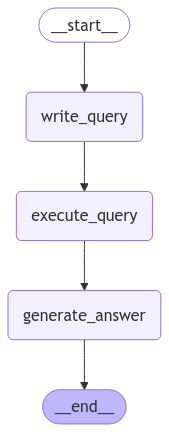

In [ ]:
get_SQL_Output()